## Premise

Generate a dataset that follows a simple system of ODEs using interative calculations. Then train a neural network to fit the dataset


##### System of ODE:

${dy_1\over dx} = y_1,$

${dy_2\over dx}=y_1-y_2,$

with initial conditions of form $y_1(0)=1$ and $y_2(0)=2$

## Neural Network Model

Implemented using Pytorch Lightning model. I'm lazy and do not want to manually implement training and epoch loops :3.

In [95]:

import torch, torch.nn as nn, torch.utils.data as data, torchvision as tv, torch.nn.functional as F
import lightning as L
import numpy as np

class Learner(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 50),
            nn.ELU(),
            nn.Linear(50, 100),
            nn.ELU(),
            nn.Linear(100, 500),
            nn.ELU(),
            nn.Linear(500, 500),
            nn.ELU(),
            nn.Linear(500, 100),
            nn.ELU(),
            nn.Linear(100, 50),
            nn.ELU(),
            nn.Linear(50, 2)
        )

    def forward(self, input):
        return self.model(input);

    def training_step(self, batch, batch_idx):
        '''
        Given x, given y = y1, y2
        '''
        x_data, y_data = batch
        y_predicted = self.model(x_data)
        
        loss = nn.SmoothL1Loss()(y_data, y_predicted)
        
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=.0003)
        return optimizer

## Dataset Generation

Implemented using torch.data.Dataset. The data is generated by iteratively generating the function by calculating small increments of dx and dy.

In [58]:
class Dataset(data.Dataset):

    def __init__(self, init, end, n, initial_condition):
        self.n = n
        self.x = torch.linspace(init, end, self.n)
        self.y = initial_condition.unsqueeze(0)
        
        dx = (end - init) / self.n
        for i in range(self.n - 1):
            dy = (torch.Tensor([self.y[-1][0], self.y[-1][0] - self.y[-1][1]]) * dx)
            new_y = self.y[-1] + dy
            self.y = torch.cat((self.y, new_y.unsqueeze(0)), 0)
    
    def __len__(self):

        return self.n

    def __getitem__(self, idx):
        x = self.x[idx, np.newaxis]
        y = self.y[idx]

        return torch.Tensor(x).to("cuda"), torch.Tensor(y).to("cuda")

In [59]:
initial_condition = torch.Tensor([1, 2])
train = Dataset(0, 8, 10000, initial_condition)

Real solution from solving it analytically

In [60]:
def y_1_analytical(x):
    return torch.exp(x)

def y_2_analytical(x):
    return 0.5 * torch.exp(x) + 1.5 * torch.exp(-x)

As you can see, the analytical and generate solution are almost the same

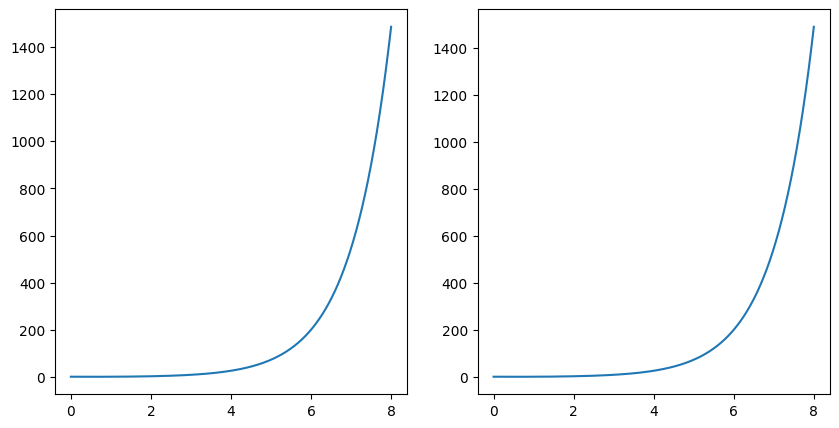

In [61]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
ax_dataset = fig.add_subplot(121)
ax_dataset.plot(train.x[:].cpu(), train.y[:, 1].cpu())

ax_analytical = fig.add_subplot(122)
ax_analytical.plot(torch.linspace(0, 8, 10000), y_2_analytical(torch.linspace(0, 8, 10000)))

## Training

In [62]:
# C:\Users\zheyu\AppData\Local\Programs\Python\Python312\Scripts
print(torch.version.cuda)

11.8


In [96]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import timeit

start_time = timeit.default_timer()

early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=0.00, patience=10000, verbose=False, mode="min", stopping_threshold=0.1)
trainer = L.Trainer(accelerator="cuda", logger=False, max_epochs=10000, callbacks=[early_stop_callback])
learner = Learner()
trainer.fit(learner, data.DataLoader(train, batch_size=1000))

print("Time Elapse: ",timeit.default_timer() - start_time)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 361 K 
-------------------------------------
361 K     Trainable params
0         Non-trainable params
361 K     Total params
1.446     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Time Elapse:  10.127762000000075


## Evaluating Predictions

In [97]:
y_hat = learner.model.forward(train.x.view(10000, 1).to("cuda"))

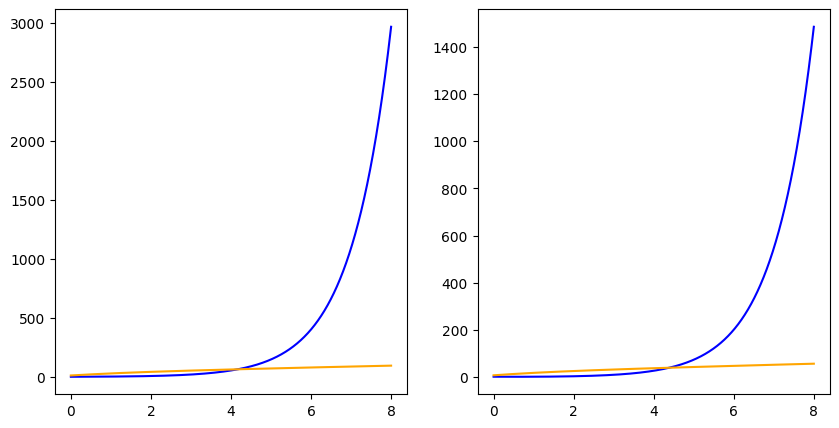

In [98]:
fig = plt.figure(figsize=(10,5))
ax_y1 = fig.add_subplot(121)
ax_y1.plot(train.x[:], train.y[:, 0], color='blue')
ax_y1.plot(train.x[:], y_hat[:, 0].cpu().detach().numpy(), color='orange')

ax_y2 = fig.add_subplot(122)
ax_y2.plot(train.x[:], train.y[:, 1], color='blue')
ax_y2.plot(train.x[:], y_hat[:, 1].cpu().detach().numpy(), color='orange')

That's surprising. The loss function wasn't converging yet the resulting graphs are pretty similar to the real functions. The loss was also pretty large...wut dis dont make no sense. :|

In [30]:
print(y_hat)
print(train.y)

tensor([[   79.8244,    42.8349],
        [   79.8188,    42.8318],
        [   79.8133,    42.8286],
        ...,
        [21236.4805, 10622.2920],
        [21255.3770, 10631.7480],
        [21274.2715, 10641.2119]])
tensor([[1.0000e+00, 2.0000e+00],
        [1.0010e+00, 1.9990e+00],
        [1.0020e+00, 1.9980e+00],
        ...,
        [2.1851e+04, 1.0926e+04],
        [2.1873e+04, 1.0936e+04],
        [2.1895e+04, 1.0947e+04]], device='cuda:0')
